## Installation

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math, copy
random.seed(9001)

# Use library for demonstrating purpose and as benchmark
from sklearn.linear_model import LinearRegression

# Mean squared error regression loss for checking the significance of our model prediction
from sklearn.metrics import mean_squared_error

# Split dataset into training set and test set
from sklearn.model_selection import train_test_split

from scipy import stats

## Load datasets

In [108]:
df = pd.read_csv("data.csv")

In [109]:
X = np.array(df["km"])
Y = np.array(df["price"])
print(f"shape of X is {X.shape[0]}")
print(f"shape of Y is {Y.shape[0]}")

shape of X is 24
shape of Y is 24


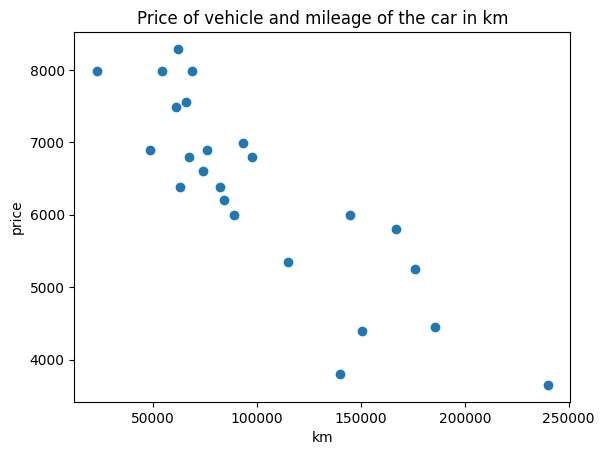

In [110]:
plt.scatter(X, Y)
plt.title("Price of vehicle and mileage of the car in km")
plt.xlabel("km")
plt.ylabel("price")
plt.show()

## Benchmark with sklearn library's linear regression

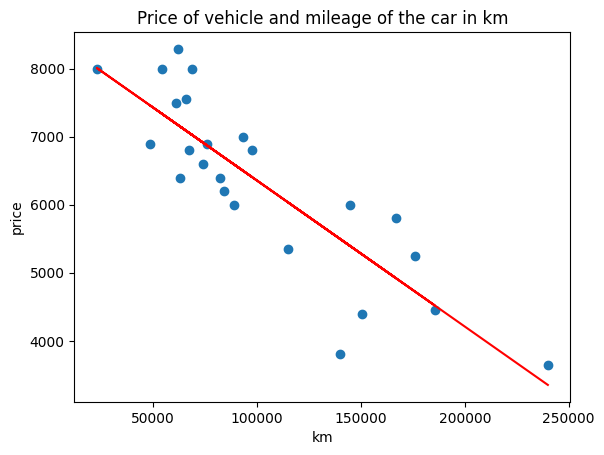

In [111]:
reg = stats.linregress(X, Y)
plt.scatter(X, Y)
plt.title("Price of vehicle and mileage of the car in km")
plt.xlabel("km")
plt.ylabel("price")
plt.plot(X, X * reg.slope + reg.intercept, "r")
plt.show()

# Build our own Linear Regression Model

### Start by normalizing input data (km)

In [112]:
def normalize(x):
    """
    x: np array of feature X
    """
    mean = x.mean()
    std = x.std()
    return (x - mean) / std

In [113]:
X_norm = normalize(X)

## Split dataset into training set and test set
For a small datasets, a common ratio is 80:20 split between training and test sets

In [114]:
x_train, x_test, y_train, y_test = train_test_split(X_norm, Y)

In [115]:
print(f"size of x_train is {x_train.shape[0]}")
print(f"size of x_test is {x_test.shape[0]}")

size of x_train is 18
size of x_test is 6


## Computing Cost
The term 'cost' is a measure how well our model is predicting the target price of the car.

The equation for cost with one variable is:
  $$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2 \tag{1}$$ 
 
where 
  $$f_{w,b}(x^{(i)}) = wx^{(i)} + b \tag{2}$$
  
- $f_{w,b}(x^{(i)})$ is our prediction for example $i$ using parameters $w,b$.  
- $(f_{w,b}(x^{(i)}) -y^{(i)})^2$ is the squared difference between the target value and the prediction.   
- These differences are summed over all the $m$ examples and divided by `2m` to produce the cost, $J(w,b)$.  

In [116]:
def compute_cost(x, y, w, b):
    """
    Computes the cost function for linear regression.
    
    Args:
      x (ndarray (m,)): Data, m examples 
      y (ndarray (m,)): target values
      w,b (scalar)    : model parameters  
    
    Returns
        total_cost (float): The cost of using w,b as the parameters for linear regression
               to fit the data points in x and y
    """
    # Number of training examples
    m = x.shape[0]
    
    pred = np.dot(x, w) + b
    cost = np.sum((pred - y)**2)/(2*m)
    return cost

## Gradient Descent


*gradient descent* is as:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3}  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$
where, parameters $w$, $b$ are updated simultaneously.  
The gradient is defined as:
$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \tag{4}\\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \tag{5}\\
\end{align}
$$

Here *simultaniously* means that you calculate the partial derivatives for all the parameters before updating any of the parameters.

### Compute Gradient
`compute_gradient`  implements (4) and (5) above and returns $\frac{\partial J(w,b)}{\partial w}$,$\frac{\partial J(w,b)}{\partial b}$.

In [117]:
def compute_gradient(x, y, w, b):
    """
    Computes the gradient for linear regression 
    Args:
      x (ndarray (m,)): Data, m examples 
      y (ndarray (m,)): target values
      w,b (scalar)    : model parameters  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
     """
    # Number of training examples
    m = x.shape[0]
    dj_dw = 0
    dj_db = 0
    
    pred = np.dot(x, w) + b
    diff = pred - y
    
    dj_dw = np.sum(np.dot(diff, x))/m
    dj_db = np.sum(diff)/m
    
    return dj_dw, dj_db

###  Gradient Descent
Now that gradients can be computed,  gradient descent, described in equation (3) above can be implemented below in `gradient_descent`. The details of the implementation are described in the comments. Below, you will utilize this function to find optimal values of $w$ and $b$ on the training data.

In [118]:
def gradient_descent(x, y, w_in, b_in, alpha, num_iters, cost_function, gradient_function):
    """
    Performs gradient descent to fit w,b. Updates w,b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      x (ndarray (m,))  : Data, m examples 
      y (ndarray (m,))  : target values
      w_in,b_in (scalar): initial values of model parameters  
      alpha (float):     Learning rate
      num_iters (int):   number of iterations to run gradient descent
      cost_function:     function to call to produce cost
      gradient_function: function to call to produce gradient
      
    Returns:
      w (scalar): Updated value of parameter after running gradient descent
      b (scalar): Updated value of parameter after running gradient descent
      J_history (List): History of cost values
      p_history (list): History of parameters [w,b] 
      """
    
    w = copy.deepcopy(w_in) #deepcopy w to avoid overwriting it
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    p_history = []
    b = b_in
    w = w_in
    
    for i in range(num_iters):
        
        dj_dw, dj_db = compute_gradient(x, y, w, b)
        
        # update parameters
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        
        # Save cost J at end of each iteration
        if (i < 100000):
            J_history.append(cost_function(x, y, w, b))
            p_history.append([w, b])
            
        if (i % math.ceil(num_iters/10) == 0):
            print(f"Iteration {i:4}: Cost {J_history[-1]:0.2e} ",
                  f"dj_dw: {dj_dw: 0.3e}, dj_db: {dj_db: 0.3e}  ",
                  f"w: {w: 0.3e}, b:{b: 0.5e}")
            
    return w, b, J_history, p_history

In [94]:
# initialize parameters
w_init = random.randint(0, 1)
b_init = 0
# parameters for gradient descent
iterations = 10000
alpha = 1.0e-2 # 0.01
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(x_train ,y_train, w_init, b_init, alpha, 
                                                    iterations, compute_cost, compute_gradient)
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 2.03e+07  dj_dw:  1.085e+03, dj_db: -6.266e+03   w: -9.846e+00, b: 6.26633e+01
Iteration 1000: Cost 2.52e+05  dj_dw:  6.699e-02, dj_db: -3.042e-01   w: -1.162e+03, b: 6.33158e+03
Iteration 2000: Cost 2.52e+05  dj_dw:  3.332e-06, dj_db: -1.491e-05   w: -1.162e+03, b: 6.33188e+03
Iteration 3000: Cost 2.52e+05  dj_dw:  1.637e-10, dj_db: -7.320e-10   w: -1.162e+03, b: 6.33188e+03
Iteration 4000: Cost 2.52e+05  dj_dw:  1.115e-11, dj_db: -4.507e-11   w: -1.162e+03, b: 6.33188e+03
Iteration 5000: Cost 2.52e+05  dj_dw:  1.115e-11, dj_db: -4.507e-11   w: -1.162e+03, b: 6.33188e+03
Iteration 6000: Cost 2.52e+05  dj_dw:  1.115e-11, dj_db: -4.507e-11   w: -1.162e+03, b: 6.33188e+03
Iteration 7000: Cost 2.52e+05  dj_dw:  1.115e-11, dj_db: -4.507e-11   w: -1.162e+03, b: 6.33188e+03
Iteration 8000: Cost 2.52e+05  dj_dw:  1.115e-11, dj_db: -4.507e-11   w: -1.162e+03, b: 6.33188e+03
Iteration 9000: Cost 2.52e+05  dj_dw:  1.115e-11, dj_db: -4.507e-11   w: -1.162e+03, b: 6.33188e+03


In [123]:
# initialize parameters
w_init = random.randint(0, 1)
b_init = 0
# parameters for gradient descent
iterations = 10000
alpha = 1.0e-2 # 0.01
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(X / 10000 ,Y, w_init, b_init, alpha, 
                                                    iterations, compute_cost, compute_gradient)
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 8.74e+06  dj_dw: -5.816e+04, dj_db: -6.322e+03   w:  5.826e+02, b: 6.32173e+01
Iteration 1000: Cost 3.44e+05  dj_dw:  1.750e+01, dj_db: -2.226e+02   w: -1.294e+02, b: 7.41753e+03
Iteration 2000: Cost 2.25e+05  dj_dw:  2.242e+00, dj_db: -2.851e+01   w: -2.036e+02, b: 8.36098e+03
Iteration 3000: Cost 2.23e+05  dj_dw:  2.872e-01, dj_db: -3.653e+00   w: -2.131e+02, b: 8.48184e+03
Iteration 4000: Cost 2.23e+05  dj_dw:  3.679e-02, dj_db: -4.679e-01   w: -2.143e+02, b: 8.49732e+03
Iteration 5000: Cost 2.23e+05  dj_dw:  4.713e-03, dj_db: -5.994e-02   w: -2.145e+02, b: 8.49931e+03
Iteration 6000: Cost 2.23e+05  dj_dw:  6.038e-04, dj_db: -7.679e-03   w: -2.145e+02, b: 8.49956e+03
Iteration 7000: Cost 2.23e+05  dj_dw:  7.735e-05, dj_db: -9.837e-04   w: -2.145e+02, b: 8.49959e+03
Iteration 8000: Cost 2.23e+05  dj_dw:  9.909e-06, dj_db: -1.260e-04   w: -2.145e+02, b: 8.49960e+03
Iteration 9000: Cost 2.23e+05  dj_dw:  1.269e-06, dj_db: -1.614e-05   w: -2.145e+02, b: 8.49960e+03


### Cost versus iterations of gradient descent 
A plot of cost versus iterations is a useful measure of progress in gradient descent. Cost should always decrease in successful runs. The change in cost is so rapid initially, it is useful to plot the initial decent on a different scale than the final descent. In the plots below, note the scale of cost on the axes and the iteration step.

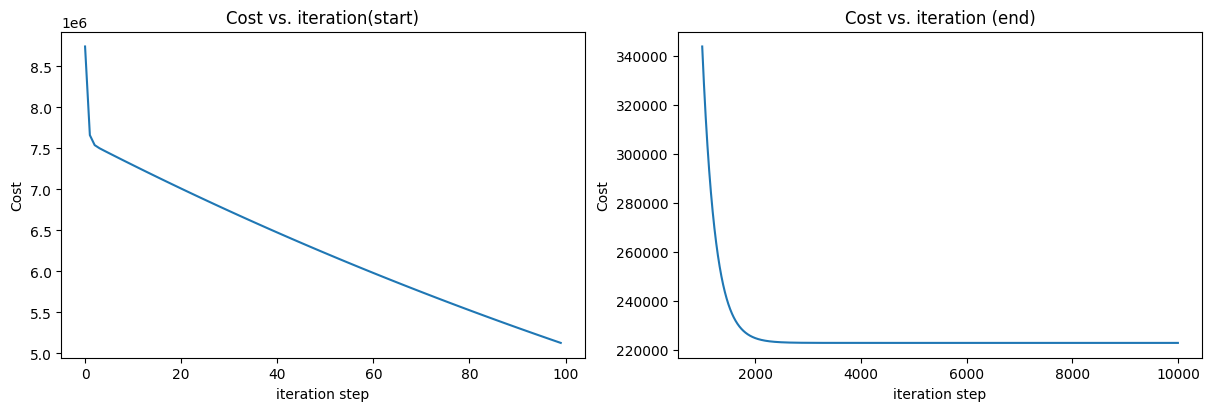

In [124]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))
ax1.plot(J_hist[:100])
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step') 
plt.show()

## Analyze performance on test set
Applying the trained model to the test set allows us to see if the model has successfully learned or not. For regression, the most popular performance measures are R squared and the root mean squared error (RMSE)

## Predictions
Now that you have discovered the optimal values for the parameters $w$ and $b$, you can now use the model to predict housing values based on our learned parameters. As expected, the predicted values are nearly the same as the training values for the same housing. Further, the value not in the prediction is in line with the expected value.

In [97]:
def predict(x, w, b):
    """
    Performs prediction.
    
    Args:
      x (ndarray (m,))  : Data, m examples 
      w, b (scalar): values of model parameters  
      
    Returns:
      w (scalar): Updated value of parameter after running gradient descent
      b (scalar): Updated value of parameter after running gradient descent
      J_history (List): History of cost values
      p_history (list): History of parameters [w,b] 
      """
    y = np.zeros(x.shape[0])
    y = np.dot(x, w) + b
    return y

In [125]:
predictions = predict(x_test, w_final, b_final)

In [126]:
predictions

array([8570.58810595, 8824.74272496, 8603.7607723 , 8612.18392582,
       8318.93339572, 8187.90656312])

In [127]:
y_test

array([6200, 7990, 6900, 6600, 5999, 5250])

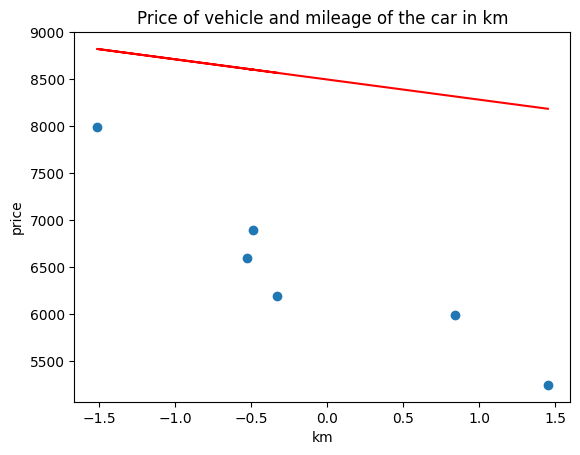

In [128]:
plt.scatter(x_test, y_test)
plt.title("Price of vehicle and mileage of the car in km")
plt.xlabel("km")
plt.ylabel("price")
plt.plot(x_test, x_test * w_final + b_final, "r")
plt.show()